In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score as auc
from sklearn.ensemble import RandomForestRegressor
import copy
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier

In [5]:
train_data = pd.read_csv('/Users/osx/Desktop/web-datamining/web_economics/dataset/train.csv')
validation = pd.read_csv('/Users/osx/Desktop/web-datamining/web_economics/dataset/validation.csv')
test_data  = pd.read_csv('/Users/osx/Desktop/web-datamining/web_economics/dataset/test.csv')

In [5]:
train_data['advertiser'].value_counts()

1458    540293
3386    498554
3427    454031
3476    346778
3358    304782
2821    231416
2259    146778
2261    120619
2997     54487
Name: advertiser, dtype: int64

# Data Exploration

In [9]:
missing_data = train_data.columns[train_data.isnull().any()]
print(missing_data.size)
missing_data = train_data[missing_data].isnull().sum()
missing_data ### NO nan in train data

0


Series([], dtype: float64)

### Training Data Exploration

In [6]:
price = train_data[['payprice','bidprice','slotprice']]
redicules_row = train_data.ix[price[price['payprice']>price['bidprice']].index,:]['click']
redicules_row = redicules_row[redicules_row==0]
train_data = train_data.drop(redicules_row.index)

In [7]:
train_data["slotsize"] = train_data.slotwidth.astype(str).str.cat(train_data.slotheight.astype(str), sep='*')

In [8]:
slot_v_numberic = train_data['slotvisibility']
values_to_takeout = ['Na','FirstView','OtherView','SecondView','ThirdView','FourthView','FifthView']
for i in values_to_takeout:
    slot_v_numberic = slot_v_numberic.drop(slot_v_numberic[slot_v_numberic == i].index,axis=0)

In [9]:
def fill_visibility_category(list):
    train_data['newslotvisibility']=train_data['slotvisibility']
    for i in list:
        if i !='FifthView':
            area_count = train_data['slotsize'][train_data['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[train_data['slotsize']==area_count.index[0]].value_counts()
#             print(fill_value.index[0])
            train_data['newslotvisibility'][train_data['slotvisibility']==i]=fill_value.index[0]
        else:
            area_count = train_data['slotsize'][train_data['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[train_data['slotsize']==area_count.index[1]].value_counts()
#             print(fill_value.index[0])
            train_data['newslotvisibility'][train_data['slotvisibility']==i]=fill_value.index[0]
#     return(train_data['newslotvisibility'])

In [10]:
values_to_takeout = ['Na','OtherView','ThirdView','FourthView','FifthView']
fill_visibility_category(values_to_takeout)
train_data['newslotvisibility'][train_data['slotvisibility']=='FirstView']='1'
train_data['newslotvisibility'][train_data['slotvisibility']=='SecondView']='2'
train_data = train_data.drop('slotvisibility',axis=1)

In [11]:
string_to_int_new_slot_v = {'0':0,'2':2,'1':1,'255':255}
string_to_int_slotformat = {'0':0,'1':1,'5':5}
train_data['newslotvisibility'] = train_data['newslotvisibility'].map(string_to_int_new_slot_v)
train_data['slotformat'] = train_data['slotformat'].map(string_to_int_slotformat)
train_data['slotformat'][train_data['slotformat'].isnull()==True]=0

In [12]:
int_to_str_new_slot_v = {0:'0',2:'2',1:'1',255:'255'}
int_to_str_slotformat = {0:'0',1:'1',5:'5'}
train_data['newslotvisibility'] = train_data['newslotvisibility'].map(int_to_str_new_slot_v)
train_data['slotformat'] = train_data['slotformat'].map(int_to_str_slotformat)

In [16]:
train_data['OS'] = train_data['useragent'].map(lambda x:x.split('_')[0])
train_data['Browser'] = train_data['useragent'].map(lambda x:x.split('_')[1])

In [18]:
train_data['Computer'] = '0'
train_data['Phone'] = '0'
train_data['Phone'][train_data['OS']=='ios'] = '1'
train_data['Phone'][train_data['OS']=='android'] = '1'
train_data['Computer'][train_data['OS']=='windows'] = '1'
train_data['Computer'][train_data['OS']=='mac'] = '1'
train_data['Computer'][train_data['OS']=='other'] = '1'
train_data['Computer'][train_data['OS']=='linux'] = '1'

In [19]:
y_payprice_train = train_data['payprice']
y_bidprice_train = train_data['bidprice']
y_click_train = train_data['click']
userinf_train_ = train_data['usertag']
userinf_train = userinf_train_.str.get_dummies(sep=',')

In [20]:
features_to_drop = ['click','bidid','logtype','slotheight','slotwidth','bidprice',\
                    'payprice','useragent','usertag','urlid','userid','slotid']
train_data = train_data.drop(features_to_drop,axis=1)

In [21]:
# domain_cal = train_data['domain'].value_counts()
# domain_cal = train_data['domain'].value_counts()
# domain_index = train_data['domain'].value_counts().index
# dom = {}
# for i in domain_index:
#     if domain_cal[i]<10000:
#         train_data['domain'][train_data['domain']==i]='others'


In [22]:
train_data = train_data.drop('url',axis=1)
train_data = train_data.drop('IP',axis=1)
train_data = train_data.drop('domain',axis=1)

###
train_data['adexchange'] = train_data['adexchange'].fillna('5')
train_data['slotprice'] = scale(train_data['slotprice'])

### Validation Data Exploration

In [28]:
validation["slotsize"] = validation.slotwidth.astype(str).str.cat(validation.slotheight.astype(str), sep='*')
slot_v_numberic = validation['slotvisibility']
values_to_takeout = ['Na','FirstView','OtherView','SecondView','ThirdView','FourthView','FifthView']
for i in values_to_takeout:
    slot_v_numberic = slot_v_numberic.drop(slot_v_numberic[slot_v_numberic == i].index,axis=0)

In [29]:
def fill_visibility_category_validation(list):
    validation['newslotvisibility']=validation['slotvisibility']
    for i in list:
        if i !='FifthView':
            area_count = validation['slotsize'][validation['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[validation['slotsize']==area_count.index[0]].value_counts()
#             print(fill_value.index[0])
            validation['newslotvisibility'][validation['slotvisibility']==i]=fill_value.index[0]
        else:
            area_count = validation['slotsize'][validation['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[validation['slotsize']==area_count.index[1]].value_counts()
#             print(fill_value.index[0])
            validation['newslotvisibility'][validation['slotvisibility']==i]=fill_value.index[0]
#     return(train_data['newslotvisibility'])

In [30]:
values_to_takeout = ['Na','OtherView','ThirdView','FourthView','FifthView']
fill_visibility_category_validation(values_to_takeout)
validation['newslotvisibility'][validation['slotvisibility']=='FirstView']='1'
validation['newslotvisibility'][validation['slotvisibility']=='SecondView']='2'
validation = validation.drop('slotvisibility',axis=1)

In [31]:
string_to_int_newslotv_v = {'0':0,'2':2,'1':1,'255':255}
string_to_int_slotformat_v = {'0':0,'1':1,'5':5}
validation['newslotvisibility'] = validation['newslotvisibility'].map(string_to_int_newslotv_v)
validation['slotformat'] = validation['slotformat'].map(string_to_int_slotformat_v)
validation['slotformat'][validation['slotformat'].isnull()==True]=0

In [32]:
int_to_str_newslotv_v = {0:'0',2:'2',1:'1',255:'255'}
int_to_str_slotformat_v = {0:'0',1:'1',5:'5'}
validation['newslotvisibility'] = validation['newslotvisibility'].map(int_to_str_newslotv_v)
validation['slotformat'] = validation['slotformat'].map(int_to_str_slotformat_v)

In [34]:
validation['OS'] = validation['useragent'].map(lambda x:x.split('_')[0])
validation['Browser'] = validation['useragent'].map(lambda x:x.split('_')[1])

In [35]:
validation['Computer'] = '0'
validation['Phone'] = '0'
validation['Phone'][validation['OS']=='ios'] = '1'
validation['Phone'][validation['OS']=='android'] = '1'
validation['Computer'][validation['OS']=='windows'] = '1'
validation['Computer'][validation['OS']=='mac'] = '1'
validation['Computer'][validation['OS']=='other'] = '1'
validation['Computer'][validation['OS']=='linux'] = '1'

In [36]:
y_click_validation = validation['click']
y_payprice_validation = validation['payprice']
y_bidprice_validation = validation['bidprice']
userinf_validation_ = validation['usertag']
userinf_validation = userinf_validation_.str.get_dummies(sep=',')
validation_features_to_drop = ['click','bidid','logtype','userid','useragent','urlid','slotid',\
                               'slotwidth','slotheight','bidprice','payprice','usertag']
validation = validation.drop(validation_features_to_drop,axis=1)

In [37]:
# domain_cal = validation['domain'].value_counts()
# domain_cal = validation['domain'].value_counts()
# domain_index = validation['domain'].value_counts().index
# dom = {}
# for i in domain_index:
#     if domain_cal[i]<1000:
#         validation['domain'][validation['domain']==i]='others'

In [38]:
validation = validation.drop('url',axis=1)
validation = validation.drop('IP',axis=1)
validation = validation.drop('domain',axis=1)
validation['adexchange'] = validation['adexchange'].fillna('5')
validation['slotprice'] = scale(validation['slotprice'])

In [39]:
# validation.to_csv('validation_exploration.csv')

### Test Data Exploration

In [41]:
test_data["slotsize"] = test_data.slotwidth.astype(str).str.cat(test_data.slotheight.astype(str), sep='*')
slot_v_numberic = test_data['slotvisibility']
values_to_takeout = ['Na','FirstView','OtherView','SecondView','ThirdView','FourthView','FifthView']
for i in values_to_takeout:
    slot_v_numberic = slot_v_numberic.drop(slot_v_numberic[slot_v_numberic == i].index,axis=0)

In [42]:
def fill_visibility_category_test(list):
    test_data['newslotvisibility']=test_data['slotvisibility']
    for i in list:
        if i !='FifthView':
            area_count = test_data['slotsize'][test_data['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[test_data['slotsize']==area_count.index[0]].value_counts()
#             print(fill_value.index[0])
            test_data['newslotvisibility'][test_data['slotvisibility']==i]=fill_value.index[0]
        else:
            area_count = test_data['slotsize'][test_data['slotvisibility']==i].value_counts()
            fill_value = slot_v_numberic[test_data['slotsize']==area_count.index[1]].value_counts()
#             print(fill_value.index[0])
            test_data['newslotvisibility'][test_data['slotvisibility']==i]=fill_value.index[0]
#     return(train_data['newslotvisibility'])

In [43]:
values_to_takeout = ['Na','OtherView','ThirdView','FourthView','FifthView']
fill_visibility_category_test(values_to_takeout)
test_data['newslotvisibility'][test_data['slotvisibility']=='FirstView']='1'
test_data['newslotvisibility'][test_data['slotvisibility']=='SecondView']='2'
test_data = test_data.drop('slotvisibility',axis=1)

In [44]:
string_to_int_new_slot_t = {'0':0,'2':2,'1':1,'255':255}
string_to_int_slotformat_t = {'0':0,'1':1,'5':5}
test_data['newslotvisibility'] = test_data['newslotvisibility'].map(string_to_int_new_slot_t)#.astype(int)
test_data['slotformat'] = test_data['slotformat'].map(string_to_int_slotformat_t)
test_data['slotformat'][test_data['slotformat'].isnull()==True]=0

In [45]:
int_to_str_newslotv_t = {0:'0',2:'2',1:'1',255:'255'}
int_to_str_slotformat_t = {0:'0',1:'1',5:'5'}
test_data['newslotvisibility'] = test_data['newslotvisibility'].map(int_to_str_newslotv_t)
test_data['slotformat'] = test_data['slotformat'].map(int_to_str_slotformat_t)

In [46]:
# plt.scatter(x=test_data['region'].values,y=test_data['city'].values)
# plt.show()

In [47]:
test_data['OS'] = test_data['useragent'].map(lambda x:x.split('_')[0])
test_data['Browser'] = test_data['useragent'].map(lambda x:x.split('_')[1])

In [48]:
test_data['Computer'] = '0'
test_data['Phone'] = '0'
test_data['Phone'][test_data['OS']=='ios'] = '1'
test_data['Phone'][test_data['OS']=='android'] = '1'
test_data['Computer'][test_data['OS']=='windows'] = '1'
test_data['Computer'][test_data['OS']=='mac'] = '1'
test_data['Computer'][test_data['OS']=='other'] = '1'
test_data['Computer'][test_data['OS']=='linux'] = '1'

In [49]:
userinf_test_ = test_data['usertag']
userinf_test = userinf_test_.str.get_dummies(sep=',')

test_features_to_drop = ['bidid','logtype','userid','useragent','urlid','slotid',\
                               'slotwidth','slotheight','usertag']
test_data = test_data.drop(test_features_to_drop,axis=1)

In [50]:
# domain_cal = test_data['domain'].value_counts()
# domain_cal = test_data['domain'].value_counts()
# domain_index = test_data['domain'].value_counts().index
# dom = {}
# for i in domain_index:
#     if domain_cal[i]<1000:
#         test_data['domain'][test_data['domain']==i]='others'


In [51]:
test_data = test_data.drop('url',axis=1)
test_data = test_data.drop('IP',axis=1)
test_data = test_data.drop('domain',axis=1)
test_data['adexchange'] = test_data['adexchange'].fillna('5')
test_data['slotprice'] = scale(test_data['slotprice'])

In [52]:
# test_data.to_csv('test_exploration')

### Dummy Data

In [54]:
all_data = pd.concat((train_data,validation,test_data),ignore_index=True)
dummy_all_data = pd.get_dummies(all_data)
dummy_all_userinf = pd.concat((userinf_train,userinf_validation,userinf_test),ignore_index=True)
dummy_total_data = pd.concat((dummy_all_data,dummy_all_userinf),axis=1)
y_clicl_vt = pd.concat((y_click_train,y_click_validation),ignore_index=True)

In [55]:
train_data_dummy = dummy_all_data[:2664207] 
validation_dummy = dummy_all_data[2664207:2963956]
test_data_dummy = dummy_all_data[2963956:]
click_t = y_clicl_vt[:2664207]
click_v = y_clicl_vt[2664207:]

# Train Model

## Classifier

### Logistic Regression-All advertiser

In [68]:
# x1 = train_data_dummy
# y1 = y_click_train
# #--------------------- choose the best parameters for LogisticRegression ————————————————————————————
# c_range = np.linspace(start=0.001,stop=5,num=10) 
# tuned_parameters = [{'C': c_range,"solver":["sag",'liblinear'],"penalty":["l2"],
#                      "class_weight":["balanced"]}]
# # scores=["accuracy"]
# lr_model=GridSearchCV(LogisticRegression(max_iter=500),param_grid=tuned_parameters,scoring="accuracy",cv=5,n_jobs=-1)
# lr_model.fit(x1, y1)

# print("parameters selected: ",lr_model.best_params_)
# print(" ")
# print("Train set:")
# print(score+":",lr_model.best_score_)
# print(" ")

# #--------------------- find the model -------
# lr = LogisticRegression(C=lr_model.best_params_["C"],class_weight=lr_model.best_params_["class_weight"]\
#                          ,penalty=lr_model.best_params_["penalty"],solver=lr_model.best_params_["solver"],n_jobs=-1)
# LR_model = lr.fit(x1,y1) 

# y_predict_LR = LR_model.predict.proba(validation_dummy)

In [70]:
x = train_data_dummy
y = y_click_train
lr = LogisticRegression(class_weight = 'balanced',penalty='l2',solver='liblinear',n_jobs=-1)
LR_model = lr.fit(x,y) 

y_predict_LR = LR_model.predict_proba(validation_dummy)

In [71]:
y_lr = y_predict_LR[:,1]

### Logistic Regression for different Advertiser

In [72]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
# validation pred_collect = pd.DataFrame()
click_LR_pred = copy.deepcopy(validation_dummy['advertiser'])
# validation_dummy = validation_dummy.drop('advertiser',axis=1)
z2 = validation_dummy.drop('advertiser',axis=1)

In [73]:
x2 = train_data_dummy.drop('advertiser',axis=1)
y2 = click_t

for adver in advertiser_set:
    lr = LogisticRegression(class_weight = 'balanced',penalty='l2',solver='liblinear',n_jobs=-1)
    LR_model = lr.fit(x2[train_data_dummy['advertiser']==adver],y2[train_data_dummy['advertiser']==adver]) 
    precollect_LR = LR_model.predict_proba(z2[validation_dummy['advertiser']==adver])
    click_LR_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]

In [74]:
y_ad_lr = np.array(click_LR_pred)

### XGBoost Classifier ---All Advertiser

In [75]:
# param_to_tuned = {'max_depth':[3,6,8],
#                   'seed':[1337],
#                   'silent':[1],
#                   'n_estimators':[500,700,300],
#                   'learning_rate':np.linspace(0.01,0.6,6),
#                   'objective':['binary:logistic'],
#                   'subsample':[0.1,0.8],
#                   'colsample_bytree':[0.7],
#                   'gamma':[0,1,0.5],
#                   'min_child_weight':[0,0.5,1.5]}
# xgb_model = xgb.XGBClassifier()    
# XGB_Model = GridSearchCV(xgb_model, param_grid = param_to_tuned, scoring='roc_auc',\
#                          cv=StratifiedKFold(y_click_train,n_folds=10,shuffle=True),\
#                           refit=True,return_train_score=True)
# t = time.time()
# XGB_Model.fit(train_data_dummy, y_click_train)
# print('model training time:',round((time.time()-t)/60,3),'minutes\n')
# print('optimal parameter:')
# print('max_depth:',XGB_Model.best_params_['max_depth'])
# print('n_estimators:',XGB_Model.best_params_['n_estimators'])
# print('learning_rate:',XGB_Model.best_params_['learning_rate'])
# print('subsample:',XGB_Model.best_params_['subsample'])
# print('gamma:',XGB_Model.best_params_['gamma'])
# print('min_child_weight:',XGB_Model.best_params_['min_child_weight'])

In [77]:
xgb_model = xgb.XGBClassifier(learning_rate=0.01,max_depth=6,\
                             n_estimators=700,).fit(train_data_dummy,click_t)    
y_predict_xgb = xgb_model.predict_proba(validation_dummy)

In [ ]:
y_xgb = y_predict_xgb[:,1]

### XGBoost for different Advertiser

In [297]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_XGB_pred = copy.deepcopy(validation_dummy['advertiser'])
z4 = validation_dummy.drop('advertiser',axis=1)

In [298]:
x4 = train_data_dummy.drop('advertiser',axis=1)
y4 = click_t

for adver in advertiser_set:
    XGB_click = xgb.XGBClassifier(colsample_bytree=0.2,
                                       gamma=0.0, 
                                       learning_rate=0.01,
                                       max_depth=6,
                                       min_child_weight=1.5,
                                       n_estimators=700,                                                                  
                                       reg_alpha=0.9,
                                       reg_lambda=0.7,
                                       subsample=0.2,
                                       seed=42,
                                       silent=1).fit(x4[train_data_dummy['advertiser']==adver],\
                                                     y4[train_data_dummy['advertiser']==adver])
    precollect_XGB = XGB_click.predict_proba(z4[validation_dummy['advertiser']==adver])
    click_XGB_pred[validation_dummy['advertiser']==adver]=precollect_XGB[:,1]
        
    

In [300]:
y_ad_xgb = np.array(click_XGB_pred)

### Random Forest for All advertiser

In [ ]:
# param_to_tuned = {'max_depth':[3,6,8],
#                   'n_estimators':[500,700,300],
#                   'min_samples_split':[3,5,10],
#                   'min_samples_leaf':[1,3],
#                   'min_weight_fraction_leaf':[0],
#                   'max_leaf_nodes':[None],
#                   'oob_score':[False],
#                   'bootstrap':[True],
#                   'class_weight':['balanced']}
# rfc_model = RandomForestClassifier()    
# rfc_Model = GridSearchCV(rfc_model, param_grid = param_to_tuned,cv10,refit=True,return_train_score=True)
# t = time.time()
# rfc_Model.fit(train_data_dummy, y_click_train)
# print('model training time:',round((time.time()-t)/60,3),'minutes\n')
# print('optimal parameter:')
# print('max_depth:',rfc_Model.best_params_['max_depth'])
# print('n_estimators:',rfc_Model.best_params_['n_estimators'])
# print('min_samples_split:',rfc_Model.best_params_['min_samples_split'])
# print('min_samples_leaf:',rfc_Model.best_params_['min_samples_leaf'])

In [38]:
rf = RandomForestClassifier(max_depth=15,n_estimators=500,class_weight='balanced').fit(train_data_dummy,click_t)
rf_all = rf.predict_proba(validation_dummy)

In [41]:
y_rf = rf_all[:,1]

### Random forest for Different advertiser

In [49]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_rfc_pred = copy.deepcopy(validation_dummy['advertiser'])
z5 = validation_dummy.drop('advertiser',axis=1)

In [50]:
x5 = train_data_dummy.drop('advertiser',axis=1)
y5 = click_t

for adver in advertiser_set:
    rfc_click = RandomForestClassifier(max_depth=6,\
                                       n_estimators=500,\
                                       class_weight='balanced').fit(x5[train_data_dummy['advertiser']==adver],\
                                                                    y5[train_data_dummy['advertiser']==adver])
    precollect_rfc = rfc_click.predict_proba(z5[validation_dummy['advertiser']==adver])
    click_rfc_pred[validation_dummy['advertiser']==adver]=precollect_rfc[:,1]

In [52]:
y_ad_rf = np.array(click_rfc_pred)

### Gradient Boost for All advertiser

In [ ]:
# param_to_tuned = {'max_depth':[3,6,8],
#                   'loss':['deviance','exponential'],
#                   'criterion':['friedman_mse'],
#                   'n_estimators':[500,700,300],
#                   'learning_rate':np.linspace(0.01,0.6,6),
#                   'subsample':[1,0.8],
#                   'min_samples_split':[2],
#                   'min_samples_leaf':[1],}
# gb_model = GradientBoostingClassifier()    
# GB_Model = GridSearchCV(gb_model, param_grid = param_to_tuned, scoring='roc_auc',\
#                         cv=10,refit=True,return_train_score=True)
# t = time.time()
# GB_Model.fit(train_data_dummy, y_click_train)
# print('model training time:',round((time.time()-t)/60,3),'minutes\n')
# print('optimal parameter:')
# print('max_depth:',GB_Model.best_params_['max_depth'])
# print('n_estimators:',GB_Model.best_params_['n_estimators'])
# print('learning_rate:',GB_Model.best_params_['learning_rate'])
# print('subsample:',GB_Model.best_params_['subsample'])
# print('loss:',GB_Model.best_params_['loss'])

In [57]:
# gb = GradientBoostingClassifier(loss='exponential', learning_rate=0.1,\
#                                 n_estimators=500,max_depth=6).fit(train_data_dummy,click_t)
# gb_all = gb.predict_proba(validation_dummy)

In [ ]:
# y_gb = gb_all[:,1]

### Gradient Boost for different advertiser 

In [ ]:
# advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
# click_gb_pred = copy.deepcopy(validation_dummy['advertiser'])
# z6 = validation_dummy.drop('advertiser',axis=1)

In [ ]:
# x6 = train_data_dummy.drop('advertiser',axis=1)
# y6 = click_t

# for adver in advertiser_set:
#     gb_click = GradientBoostingClassifier(loss='exponential', learning_rate=0.1,n_estimators=500,\
#                                           max_depth=6).fit(x6[train_data_dummy['advertiser']==adver],\
#                                                            y6[train_data_dummy['advertiser']==adver])
#     precollect_gb = gb_click.predict_proba(z6[validation_dummy['advertiser']==adver])
#     click_gb_pred[validation_dummy['advertiser']==adver]=precollect_gb[:,1]


In [ ]:
# y_ad_gb = np.array(click_gb_pred)

### NN for All advertiser

In [67]:
# param_to_tuned = {'hidden_layer_sizes':[(100,50,2),(300,150,50)],
#                   'activation':['relu'],
#                   'solver':['adam'],
#                   'alpha':[0.0001,0.0005,0.001],
#                   'learning_rate_init':np.linspace(0.001,0.007),}
# NN_model = MLPClassifier()    
# NN_Model = GridSearchCV(NN_model, param_grid = param_to_tuned, scoring='accuracy',\
#                         cv=10,refit=True,return_train_score=True)
# t = time.time()
# NN_Model.fit(train_data_dummy, y_click_train)
# print('model training time:',round((time.time()-t)/60,3),'minutes\n')
# print('optimal parameter:')
# print('hidden_layer_sizes:',NN_Model.best_params_['hidden_layer_sizes'])
# print('alpha:',NN_Model.best_params_['alpha'])
# print('learning_rate_init:',NN_Model.best_params_['learning_rate_init'])

In [58]:
NN = MLPClassifier(hidden_layer_sizes=(300,150,50),solver='adam', alpha=0.0001).fit(train_data_dummy,click_t)
NN_all = NN.predict_proba(validation_dummy)

In [59]:
y_nn = NN_all[:,1]

### NN for different advertiser

In [61]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_NN_pred = copy.deepcopy(validation_dummy['advertiser'])
z7 = validation_dummy.drop('advertiser',axis=1)

In [63]:
x7 = train_data_dummy.drop('advertiser',axis=1)
y7 = click_t

for adver in advertiser_set:
    NN_click = MLPClassifier(hidden_layer_sizes=(300,150,50),solver='adam',\
                             alpha=0.0001).fit(x7[train_data_dummy['advertiser']==adver],\
                                               y7[train_data_dummy['advertiser']==adver])
    precollect_NN = NN_click.predict_proba(z7[validation_dummy['advertiser']==adver])
    click_NN_pred[validation_dummy['advertiser']==adver]=precollect_NN[:,1]

In [64]:
y_ad_nn = np.array(click_NN_pred)

### Extra tree model

In [ ]:
etc = ExtraTreesClassifier(n_estimators=500, criterion='gini',max_depth=6,bootstrap=True,\
                           random_state=None,class_weight='balanced').fit(train_data_dummy,click_t)
etc_all = ect.predict_proba(validation_dummy)
y_etc = etc_all[:,1]

### ETC for different advertiser

In [ ]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_etc_pred = copy.deepcopy(validation_dummy['advertiser'])
z9 = validation_dummy.drop('advertiser',axis=1)

In [ ]:
x9 = train_data_dummy.drop('advertiser',axis=1)
y9 = click_t

for adver in advertiser_set:
    etc_click = ExtraTreesClassifier(n_estimators=500, criterion='gini',max_depth=6,bootstrap=True,\
                           random_state=None,class_weight='balanced').fit(x9[train_data_dummy['advertiser']==adver],\
                                                                          y9[train_data_dummy['advertiser']==adver])
    precollect_etc = etc_click.predict_proba(z9[validation_dummy['advertiser']==adver])
    click_etc_pred[validation_dummy['advertiser']==adver]=precollect_etc[:,1]

In [ ]:
y_ad_etc = np.array(click_etc_pred)

# Final result combine results from all models

In [235]:
###For all advertisers 
y_lr = pd.read_csv('/Users/osx/Desktop/LR_All.csv')
y_xgb = pd.read_csv('/Users/osx/Desktop/XGB_All.csv')
y_rf = pd.read_csv('/Users/osx/Desktop/RF_All.csv')
y_nn = pd.read_csv('/Users/osx/Desktop/NN_All.csv')
y_etc = pd.read_csv('/Users/osx/Desktop/ET_ALL.csv')

###For different advertisers
y_ad_lr = pd.read_csv('/Users/osx/Desktop/LR_D.csv')
y_ad_xgb = pd.read_csv('/Users/osx/Desktop/LR_D.csv')
y_ad_rf = pd.read_csv('/Users/osx/Desktop/LR_D.csv')
y_ad_nn = pd.read_csv('/Users/osx/Desktop/LR_D.csv')
y_ad_etc = pd.read_csv('/Users/osx/Desktop/LR_D.csv')

In [236]:
# y_lr = y_lr.rename(columns ={'0':'lr'})
y_lr = y_lr.drop('Unnamed: 0',axis=1)
# y_xgb= y_xgb.rename(columns ={'0':'xgb'})
y_xgb = y_xgb.drop('Unnamed: 0',axis=1)
# y_rf = y_rf.rename(columns ={'0':'rf'})
y_rf = y_rf.drop('Unnamed: 0',axis=1)
# y_nn = y_nn.rename(columns ={'0':'nn'})
y_nn = y_nn.drop('Unnamed: 0',axis=1)
# y_etc = y_etc.rename(columns ={'0':'etc'})
y_etc = y_etc.drop('Unnamed: 0',axis=1)


y_ad_lr = y_ad_lr.drop('index',axis=1)
y_ad_xgb = y_ad_xgb.drop('index',axis=1)
y_ad_rf = y_ad_rf.drop('index',axis=1)
y_ad_nn = y_ad_nn.drop('index',axis=1)
y_ad_etc = y_ad_etc.drop('index',axis=1)

###### for all advertiser

In [519]:
### performance of logisitic regression
print(rmse(y_cli2ck_validation,y_lr))
print(auc(y_click_validation,y_lr))

### performance of xgboost
print(rmse(y_click_validation,y_xgb))
print(auc(y_click_validation,y_xgb))

### performance of random forest
print(rmse(y_click_validation,y_rf))
print(auc(y_click_validation,y_rf))

### performance of nerual network
print(rmse(y_click_validation,y_nn))
print(auc(y_click_validation,y_nn))


## performance of extra tree 
print(rmse(y_click_validation,y_etc))
print(auc(y_click_validation,y_etc))

###### Differen advertiser

In [520]:
### performance of logisitic regression
print(rmse(y_click_validation,y_ad_lr))
print(auc(y_click_validation,y_ad_lr))


### performance of xgboost
print(rmse(y_click_validation,y_ad_xgb))
print(auc(y_click_validation,y_ad_xgb))


### performance of random forest
print(rmse(y_click_validation,y_ad_rf))
print(auc(y_click_validation,y_ad_rf))


### performance of nerual network
print(rmse(y_click_validation,y_ad_nn))
print(auc(y_click_validation,y_ad_nn))


## performance of extra tree 
print(rmse(y_click_validation,y_ad_etc))
print(auc(y_click_validation,y_ad_etc))

In [237]:
y_average = (y_lr+y_xgb+y_rf+y_nn+y_etc)/5
y_ad_average = (y_ad_lr+y_ad_xgb+y_ad_rf+y_ad_nn+y_ad_etc)/5

In [240]:
print(rmse(y_click_validation,y_average))
print(auc(y_click_validation,y_average))
print('')
print(rmse(y_click_validation,y_ad_average))
print(auc(y_click_validation,y_ad_average))

0.252509508632
0.70316192126

0.461665612819
0.661919324883


### For each advertiser select best model

In [ ]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_various_pred = copy.deepcopy(validation_dummy['advertiser'])
z7 = validation_dummy.drop('advertiser',axis=1)

In [280]:
c_xgb = xgb.XGBClassifier(learning_rate=0.01 ,max_depth=6,n_estimators=700)
c_rf = RandomForestClassifier(max_depth=15,n_estimators=500,class_weight='balanced')
c_lr = LogisticRegression(class_weight = 'balanced',penalty='l2',solver='liblinear',n_jobs=-1)
c_nn = MLPClassifier(hidden_layer_sizes=(300,150,50),solver='adam', alpha=0.0001)
c_lda = LinearDiscriminantAnalysis(solver='svd')
c_et = ExtraTreesClassifier(n_estimators=500, criterion='gini',max_depth=6,bootstrap=True,\
                           random_state=None,class_weight='balanced')

model_set=[c_xgb,c_rf,c_lr,c_nn,c_lda,c_et]

In [ ]:
x8 = train_data_dummy.drop('advertiser',axis=1)
y8 = click_t
auc_c = []
rmse_ = []
model_c = []
for adver in advertiser_set:
    for model in model_set:
        a = model.fit(x8[train_data_dummy['advertiser']==adver],y8[train_data_dummy['advertiser']==adver])
        precollect = a.predict_proba(z7[validation_dummy['advertiser']==adver])
#         click_various_pred[validation_dummy['advertiser']==adver]=precollect_NN[:,1]
        auc_c.append(auc(click_v[validation_dummy['advertiser']==adver],precollect_NN[:,1]))
        rmse_c.append(rmse(click_v[validation_dummy['advertiser']==adver],precollect_NN[:,1]))
        model_c.append(model)
    print('Advertiser',adver)
    print('max auc',max(auc_c),'from',model_c[auc_c.index(max(auc_c))])
    print('min rmse',min(rmse_c),'from',model_c[rmse_c.index(min(rmse_c))])

##### The out put above is shown below:
Advertiser 1458
max auc 0.638388995415 from ExtraTreesClassifier
min rmse 0.0288466306273 from MLPClassifier

Advertiser 3386
max auc 0.710998369021 from XGBClassifier
min rmse 0.0244841121181 from XGBClassifier

Advertiser 3427
max auc 0.726087138871 from XGBClassifier
min rmse 0.0244841121181 from XGBClassifier

Advertiser 3476
max auc 0.726087138871 from XGBClassifier
min rmse 0.0183078721032 from MLPClassifier

Advertiser 3358
max auc 0.735850791961 from MLPClassifier
min rmse 0.0183078721032 from MLPClassifier

Advertiser 2821
max auc 0.735850791961 from MLPClassifier
min rmse 0.0183078721032 from MLPClassifier

Advertiser 2259
max auc 0.735850791961 from MLPClassifier
min rmse 0.0183078721032 from MLPClassifier

Advertiser 2261
max auc 0.735850791961 from MLPClassifier
min rmse 0.0183078721032 from MLPClassifier

Advertiser 2997
max auc 0.735850791961 from MLPClassifier
min rmse 0.0183078721032 from MLPClassifier

##### to get the results

In [ ]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_fengshou_pred = copy.deepcopy(validation_dummy['advertiser'])
z10 = validation_dummy.drop('advertiser',axis=1)
x10 = train_data_dummy.drop('advertiser',axis=1)
y10 = click_t

for adver in advertiser_set:
    if adver == 1458:
        a = c_et.fit(x10[train_data_dummy['advertiser']==adver],\
                             y10[train_data_dummy['advertiser']==adver])
        precollect_etc = a.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_etc[:,1]
    
    if adver == 3386:
        b = c_xgb.fit(x10[train_data_dummy['advertiser']==adver],\
                             y10[train_data_dummy['advertiser']==adver])
        precollect_etc = b.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_etc[:,1]
    
    if adver == 3427:
        c = c_xgb.fit(x10[train_data_dummy['advertiser']==adver],\
                              y10[train_data_dummy['advertiser']==adver])
        precollect_XGB = c.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_XGB[:,1]
        
    
    if adver == 3476:
        d = c_xgb.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = d.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 3358:
        e = c_nn.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = e.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2821:
        f = c_nn.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = f.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2259:
        g = c_nn.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = g.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2261:
        h = c_nn.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = h.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2997:
        i = c_nn.fit(x10[train_data_dummy['advertiser']==adver],\
                      y10[train_data_dummy['advertiser']==adver]) 
        precollect_LR = i.predict_proba(z10[validation_dummy['advertiser']==adver])
        click_fengshou_pred[validation_dummy['advertiser']==adver]=precollect_LR[:,1]

In [108]:
final = pd.read_csv('/Users/osx/Desktop/need_download.csv')

In [114]:
final = np.array(final[:,1])
print(rmse(y_click_validation,final))
print(auc(y_click_validation,final))

0.210678318721
0.628998950514


### Validation data testing

In [111]:
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [128]:
avg_CTR = y_click_train.sum()/len(y_click_train)
avg_CTR

0.0007634541910594785

In [123]:
y_click_validation.sum()

226

In [314]:
pd.DataFrame(final).describe()

,0
count,2.997490e+05
mean,9.369306e-02
std,1.871547e-01
min,3.740000e-13
25%,7.621400e-04
50%,1.114239e-03
75%,2.797248e-03
max,8.665485e-01


In [351]:
pd.DataFrame(final/(20*avg_CTR)).describe()

,0
count,2.997490e+05
mean,6.136128e+00
std,1.225710e+01
min,2.449394e-11
25%,4.991393e-02
50%,7.297353e-02
75%,1.831968e-01
max,5.675183e+01


In [395]:
# click_v = click_v.reset_index().drop('index',axis=1)
base_bid_1 = y_payprice_train.mean()#+0.5*y_payprice_validation.mean()
base_bid_2 = base_bid_1/4.6
base_bid_3 = base_bid_1/5.7880
base_bid_4 = y_bidprice_train.mean()
base_bid_5 = base_bid_4/17.0
base_bid_6 = base_bid_4/16.8
bidding_set = [base_bid_1,base_bid_2,base_bid_3,base_bid_4,base_bid_5,base_bid_6]
bid_number = 0
    
for j in bidding_set:
    bid_number +=1
    bidding = j*np.exp(final/(2*avg_CTR))*(np.log(final/avg_CTR)/abs(np.log(final/(avg_CTR))))
    
    impression = 0
    get_click = 0
    get_cost_1 = 0.0
    get_cost_2 = 0.0
    budget = 6250000
    for i in y_payprice_validation.index:
#         get_cost_2 += y_payprice_validation[i]
        if get_cost_1>=budget:
            break
        if y_payprice_validation[i]<bidding[i]:
            get_click += click_v.ix[i,'click']
            impression +=1.0
            get_cost_1 += y_payprice_validation[i]
    
    print(bid_number)
    print('Get',impression,'impression')
    print('Get',get_click,'clicks')
    print('Spend',get_cost_1,'money')
    print('')

1
Get 87039.0 impression
Get 84 clicks
Spend 6250038.0 money

2
Get 111187.0 impression
Get 110 clicks
Spend 6250022.0 money

3
Get 102519.0 impression
Get 101 clicks
Spend 5733950.0 money

4
Get 77129.0 impression
Get 75 clicks
Spend 6250024.0 money

5
Get 109303.0 impression
Get 108 clicks
Spend 6141418.0 money

6
Get 109777.0 impression
Get 109 clicks
Spend 6169181.0 money



In [410]:
j = base_bid_1/4.6
bidding = j*np.exp(final/(2*avg_CTR))*(np.log(final/avg_CTR)/abs(np.log(final/(avg_CTR))))
    
impression = 0
get_click = 0
get_cost_1 = 0.0
get_cost_2 = 0.0
budget = 6250000/1
for i in y_payprice_validation.index:
#         get_cost_2 += y_payprice_validation[i]
    if get_cost_1>=budget:
        break
    if y_payprice_validation[i]<bidding[i]:
        get_click += click_v.ix[i,'click']
        impression +=1.0
        get_cost_1 += y_payprice_validation[i]
    
print(bid_number)
print('Get',impression,'impression')
print('Get',get_click,'clicks')
print('Spend',get_cost_1,'money')
print('')

6
Get 111187.0 impression
Get 110 clicks
Spend 6250022.0 money



In [418]:
budget=[6250000/32,6250000/16,6250000/8,6250000/4,6250000/2,6250000]
imps = [3416,6827,13680,27799,55833,111187]
cpc = [195535/6,390665.0/11,781296.0/19,1562509.0/32,3125029.0/55,6250022.0/110]
click = [6,11,19,32,55,110]
CTR = [6/3416,11/6827,19/13680,32/27799,55/55833,110/111187]

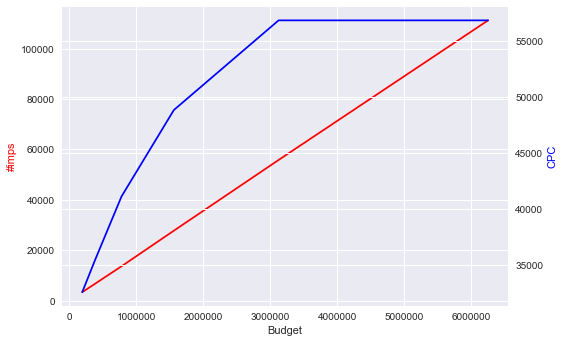

In [420]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(budget, imps, 'r-')
ax2.plot(budget, cpc, 'b-')

ax1.set_xlabel('Budget')
ax1.set_ylabel('#imps', color='r')
ax2.set_ylabel('CPC', color='b')

plt.show()

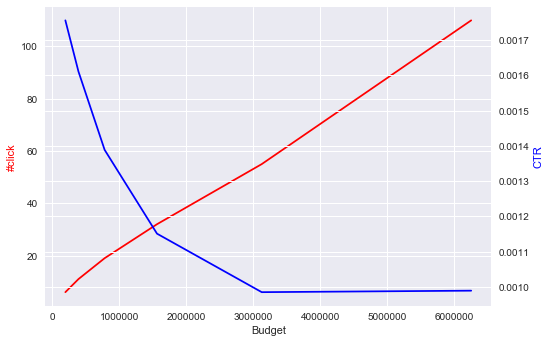

In [421]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(budget, click, 'r-')
ax2.plot(budget, CTR, 'b-')

ax1.set_xlabel('Budget')
ax1.set_ylabel('#click', color='r')
ax2.set_ylabel('CTR', color='b')

plt.show()

### Test

In [281]:
c_xgb = xgb.XGBClassifier(learning_rate=0.01 ,max_depth=6,n_estimators=700)
c_rf = RandomForestClassifier(max_depth=15,n_estimators=500,class_weight='balanced')
c_lr = LogisticRegression(class_weight = 'balanced',penalty='l2',solver='liblinear',n_jobs=-1)
c_nn = MLPClassifier(hidden_layer_sizes=(300,150,50),solver='adam', alpha=0.0001)
c_lda = LinearDiscriminantAnalysis(solver='svd')
c_et = ExtraTreesClassifier(n_estimators=500, criterion='gini',max_depth=6,bootstrap=True,\
                           random_state=None,class_weight='balanced')

model_set=[c_xgb,c_rf,c_lr,c_nn,c_lda,c_et]

In [283]:
advertiser_set = [1458,3386,3427,3476,3358,2821,2259,2261,2997]
click_fengshoulo_pred = copy.deepcopy(test_data_dummy['advertiser'])
z11 = test_data_dummy.drop('advertiser',axis=1)
x11 = train_data_dummy.drop('advertiser',axis=1)
y11 = click_t

for adver in advertiser_set:
    if adver == 1458:
        a = c_et.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver])
        precollect_etc = a.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_etc[:,1]
    
    if adver == 3386:
        b = c_xgb.fit(x11[train_data_dummy['advertiser']==adver],\
                      y11[train_data_dummy['advertiser']==adver])
        precollect_etc = b.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_etc[:,1]
    
    if adver == 3427:
        c = c_xgb.fit(x11[train_data_dummy['advertiser']==adver],\
                      y11[train_data_dummy['advertiser']==adver])
        precollect_XGB = c.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_XGB[:,1]
        
    
    if adver == 3476:
        d = c_xgb.fit(x11[train_data_dummy['advertiser']==adver],\
                      y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = d.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 3358:
        e = c_nn.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = e.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2821:
        f = c_nn.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = f.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2259:
        g = c_nn.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = g.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2261:
        h = c_nn.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = h.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]
    
    if adver == 2997:
        i = c_nn.fit(x11[train_data_dummy['advertiser']==adver],\
                     y11[train_data_dummy['advertiser']==adver]) 
        precollect_LR = i.predict_proba(z11[test_data_dummy['advertiser']==adver])
        click_fengshoulo_pred[test_data_dummy['advertiser']==adver]=precollect_LR[:,1]

In [290]:
click_fengshoulo_pred = click_fengshoulo_pred.reset_index()
click_fengshoulo_pred = click_fengshoulo_pred.drop('index',axis=1)
click_fengshoulo_pred = click_fengshoulo_pred.rename(columns={'advertiser':'CTR'})

In [292]:
click_fengshoulo_pred.to_csv('CTR_test.csv')

###### save the csv file

In [514]:
ctr_test = pd.read_csv('/Users/osx/Desktop/web-datamining/web_economics/CTR_test.csv')
test_data_bid  = pd.read_csv('/Users/osx/Desktop/web-datamining/web_economics/dataset/test.csv')
bidid = test_data_bid['bidid']
ctr_test = ctr_test.drop('Unnamed: 0',axis=1)
ctr_test['bidid'] = bidid
pCTR = ctr_test['CTR']
ctr_test['bidprice']=(base_bid_1/4.6)*np.exp(pCTR/(2*avg_CTR))*(np.log(pCTR/avg_CTR)/abs(np.log(pCTR/avg_CTR)))
Test_bidding = ctr_test.drop('CTR',axis=1)

In [518]:
Test_bidding.to_csv('Test_bidding.csv',index=False)